In [ ]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np

In [7]:
# Load the Excel file
file_name = "/Users/faazilbudhwani/Downloads/SES_2024_tidy.xlsx.coredownload.xlsx"
sheet_name = "T3.5"

# Read the data from the Excel file
df = pd.read_excel(file_name, sheet_name=sheet_name)
df = df.fillna(0)

# Treat the random 's' as 0
df['Kwh_Per_Acc_Cleaned'] = df['Kwh Per Acc'].apply(lambda x: 0 if isinstance(x, str) and 's' in x else x) 

# Filter the data for the year 2024 and 'Dwelling Type' as 'overall'
filtered_data = df[(df['Year'] == 2024) & (df['Dwelling Type'] == 'Overall') & (df['Month'] == 'Annual')]

# Calculate total consumption per region
regions = ['Central Region', 'East Region', 'North East Region', 'North Region', 'West Region']
demand_kW_per_region = {
    region: filtered_data[filtered_data['Region'] == region]['Kwh_Per_Acc_Cleaned'].astype(float).sum()
    for region in regions
}

demand_kW_per_region

{'Central Region': np.float64(12698.599999999999),
 'East Region': np.float64(3884.1000000000004),
 'North East Region': np.float64(3428.7000000000003),
 'North Region': np.float64(3354.5),
 'West Region': np.float64(2853.1000000000004)}

In [8]:
df_carpark = pd.read_csv('Checkmark2.csv')

# Calculate the number of car parks per region
carpark_per_region = {
    region: df_carpark[df_carpark['region'] == region].shape[0]
    for region in regions
}

# Output the result
carpark_per_region

{'Central Region': 541,
 'East Region': 400,
 'North East Region': 493,
 'North Region': 303,
 'West Region': 506}

In [9]:
# Define other parameters
types_of_panels = ['Monocrystalline', 'Polycrystalline', 'Thin-film']
efficiency = {'Monocrystalline': 0.15, 'Polycrystalline': 0.13, 'Thin-film': 0.07}
var_cost = {'Monocrystalline': 266.125, 'Polycrystalline': 265.85, 'Thin-film': 265.5}
fixed_cost = 39457.75
available_space_m2 = 2559.5
budget_limit = 40_000_000 # Budget limit in dollars

# Calculate the total area by region constraint
area_by_region_constraint = {
    region: carpark_per_region[region] * available_space_m2
    for region in carpark_per_region
}

area_by_region_constraint

{'Central Region': 1384689.5,
 'East Region': 1023800.0,
 'North East Region': 1261833.5,
 'North Region': 775528.5,
 'West Region': 1295107.0}

In [10]:
# Create a new model
model = gp.Model("solar_optimization")

# Decision variables
x = model.addVars(regions, types_of_panels, vtype=GRB.INTEGER, name="x")
y = model.addVars(regions, vtype=GRB.BINARY, name="y")

In [11]:
model.setObjective(
    gp.quicksum(fixed_cost * y[region] + gp.quicksum(var_cost[panel] * x[region, panel] for panel in types_of_panels) for region in regions),
    GRB.MINIMIZE
)

<h3>Can budget by maximum number of panels you want to build if you do this way it's 1000 in the last line</h3>

In [12]:
# # Constraints
# for i in regions:
#     # Demand constraint with maximum power per panel
#     model.addConstr(
#         gp.quicksum(efficiency[j] * max_power_per_panel_kW * x[i, j] for j in types_of_panels) >= demand_kW_per_region[i],
#         name=f"demand_{i}"
#     )

#     # Space constraint
#     model.addConstr(
#         gp.quicksum(x[i, j] * panel_area_m2 for j in types_of_panels) <= available_space_m2,
#         name=f"space_{i}"
#     )

#     # Installation constraints
#     for j in types_of_panels:
#         model.addConstr(x[i, j] <= 1000 * y[i, j], name=f"install_{i}_{j}")

<h3>Or if you do this way then you budget by the money set in the cell above. For now I put $1 mil</h3>

In [13]:
# Add constraints
for region in regions:
    model.addConstr(gp.quicksum(efficiency[panel] * x[region, panel] for panel in types_of_panels) >= demand_kW_per_region[region], f"Demand_Constraint_{region}")
    model.addConstr(gp.quicksum(10*x[region, panel] for panel in types_of_panels) <= area_by_region_constraint[region], f"Space_Constraint_{region}")
    model.addConstr(fixed_cost * y[region] + gp.quicksum(var_cost[panel] * x[region, panel] for panel in types_of_panels) <= budget_limit, f"Budget_Constraint_{region}")
    for panel in types_of_panels:
        model.addConstr(x[region, panel] <= GRB.INFINITY * y[region], f"Big_M_Constraint_{region}_{panel}")
        model.addConstr(x[region, panel] >= 0, f"Non-Negativity_{region}_{panel}")
        

# Optimize the model
model.optimize()

# Print the results
if model.status == GRB.OPTIMAL:
    for region in regions:
        print(f"y[{region}] = {y[region].X}")
        for panel in types_of_panels:
            print(f"x[{region},{panel}] = {x[region,panel].X}")
else:
    print("No optimal solution found.")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 24.0.0 24A348)

CPU model: Intel(R) Core(TM) i7-8559U CPU @ 2.70GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 45 rows, 20 columns and 95 nonzeros
Model fingerprint: 0xc661d90b
Variable types: 0 continuous, 20 integer (5 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+100]
  Objective range  [3e+02, 4e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+03, 4e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 43 rows and 17 columns
Presolve time: 0.01s
Presolved: 2 rows, 3 columns, 6 nonzeros
Variable types: 0 continuous, 3 integer (0 binary)
Found heuristic solution: objective 4.671461e+07

Root relaxation: interrupted, 0 iterations, 0.00 seconds (0.00 work units)

Explored 1 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 8 (of 

In [14]:
# Set the txt file to see the logs
model.setParam('LogFile', 'gurobi_log.txt')
model.setParam('OutputFlag', 1) 

# Optimize the model
model.optimize()

# In case we mess up and we wanna see the variables 
if model.status == GRB.INFEASIBLE:
    model.computeIIS()
    model.write("model.ilp")

Set parameter LogFile to value "gurobi_log.txt"
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 24.0.0 24A348)

CPU model: Intel(R) Core(TM) i7-8559U CPU @ 2.70GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 45 rows, 20 columns and 95 nonzeros
Model fingerprint: 0xc661d90b
Variable types: 0 continuous, 20 integer (5 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+100]
  Objective range  [3e+02, 4e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+03, 4e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolved: 2 rows, 3 columns, 6 nonzeros

Continuing optimization...


Explored 1 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 4.67146e+07 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.671460557500e+07, best bound 4.67144423250

In [15]:
# Print the results
if model.status == GRB.OPTIMAL:
    print("Optimal solution found:")
    for i in regions:
        for j in types_of_panels:
            print(f"Region: {i}, {j}: {x[i, j].x} kwp System, Build: {y[i].x}")
    print(f"Total Cost: ${model.objVal}")
else:
    print("No optimal solution found.")

Optimal solution found:
Region: Central Region, Monocrystalline: 84657.0 kwp System, Build: 1.0
Region: Central Region, Polycrystalline: 0.0 kwp System, Build: 1.0
Region: Central Region, Thin-film: 1.0 kwp System, Build: 1.0
Region: East Region, Monocrystalline: 25894.0 kwp System, Build: 1.0
Region: East Region, Polycrystalline: -0.0 kwp System, Build: 1.0
Region: East Region, Thin-film: -0.0 kwp System, Build: 1.0
Region: North East Region, Monocrystalline: 22858.0 kwp System, Build: 1.0
Region: North East Region, Polycrystalline: 0.0 kwp System, Build: 1.0
Region: North East Region, Thin-film: 0.0 kwp System, Build: 1.0
Region: North Region, Monocrystalline: 22359.0 kwp System, Build: 1.0
Region: North Region, Polycrystalline: 5.0 kwp System, Build: 1.0
Region: North Region, Thin-film: -0.0 kwp System, Build: 1.0
Region: West Region, Monocrystalline: 19019.0 kwp System, Build: 1.0
Region: West Region, Polycrystalline: 2.0 kwp System, Build: 1.0
Region: West Region, Thin-film: 0.0 k

In [16]:
for constr in model.getConstrs():
    print(f"Constraint: {constr.ConstrName}, Expression: {model.getRow(constr)}, RHS: {constr.RHS}")

Constraint: Demand_Constraint_Central Region, Expression: 0.15 x[Central Region,Monocrystalline] + 0.13 x[Central Region,Polycrystalline] + 0.07 x[Central Region,Thin-film], RHS: 12698.599999999999
Constraint: Space_Constraint_Central Region, Expression: 10.0 x[Central Region,Monocrystalline] + 10.0 x[Central Region,Polycrystalline] + 10.0 x[Central Region,Thin-film], RHS: 1384689.5
Constraint: Budget_Constraint_Central Region, Expression: 266.125 x[Central Region,Monocrystalline] + 265.85 x[Central Region,Polycrystalline] + 265.5 x[Central Region,Thin-film] + 39457.75 y[Central Region], RHS: 40000000.0
Constraint: Big_M_Constraint_Central Region_Monocrystalline, Expression: x[Central Region,Monocrystalline] + -1e+100 y[Central Region], RHS: 0.0
Constraint: Non-Negativity_Central Region_Monocrystalline, Expression: x[Central Region,Monocrystalline], RHS: 0.0
Constraint: Big_M_Constraint_Central Region_Polycrystalline, Expression: x[Central Region,Polycrystalline] + -1e+100 y[Central Re

In [17]:
# Check if the model is infeasible
if model.status == GRB.INFEASIBLE:
    # Compute the IIS
    model.computeIIS()
    
    # Print the constraints in the IIS
    print("Constraints in the IIS:")
    for constr in model.getConstrs():
        if constr.IISConstr:
            print(constr.ConstrName)
    
    # Print the variable bounds in the IIS
    print("Variable bounds in the IIS:")
    for var in model.getVars():
        if var.IISLB:
            print(f"{var.VarName} (lower bound)")
        if var.IISUB:
            print(f"{var.VarName} (upper bound)")
else:
    print("Optimal solution found.")

Optimal solution found.


<h3>Sensitvity Analysis on Efficiency</h3>

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 24.0.0 24A348)

CPU model: Intel(R) Core(TM) i7-8559U CPU @ 2.70GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 45 rows, 20 columns and 95 nonzeros
Model fingerprint: 0x4f502f62
Variable types: 0 continuous, 20 integer (5 binary)
Coefficient statistics:
  Matrix range     [6e-02, 1e+100]
  Objective range  [3e+02, 4e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+03, 4e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 43 rows and 17 columns
Presolve time: 0.04s
Presolved: 2 rows, 3 columns, 6 nonzeros
Variable types: 0 continuous, 3 integer (0 binary)
Found heuristic solution: objective 5.188355e+07

Root relaxation: interrupted, 0 iterations, 0.00 seconds (0.00 work units)

Explored 1 nodes (0 simplex iterations) in 0.12 seconds (0.00 work units)
Thread count was 8 (of 

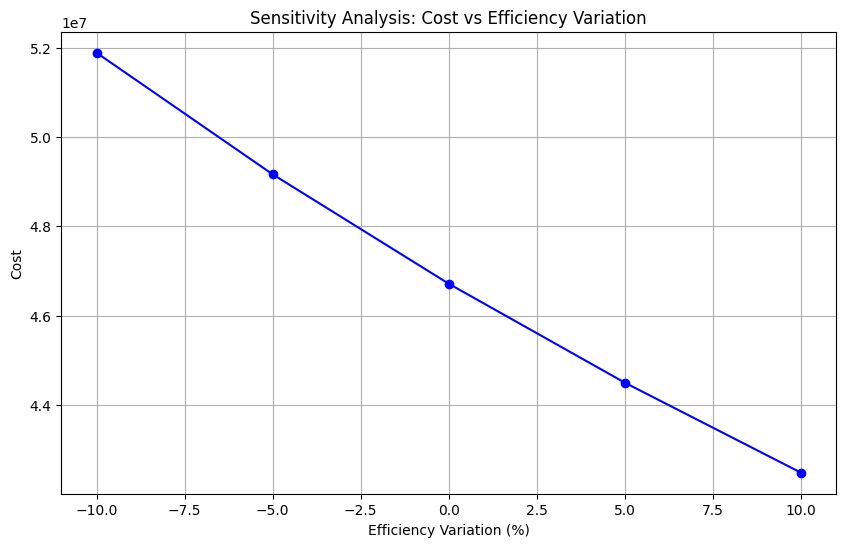

In [24]:
import matplotlib.pyplot as plt

efficiency_variations = [
    {"variation": -10, "efficiency": {'Monocrystalline': 0.135, 'Polycrystalline': 0.117, 'Thin-film': 0.063}},
    {"variation": -5, "efficiency": {'Monocrystalline': 0.1425, 'Polycrystalline': 0.1235, 'Thin-film': 0.0665}},
    {"variation": 0, "efficiency": {'Monocrystalline': 0.15, 'Polycrystalline': 0.13, 'Thin-film': 0.07}},  # Baseline
    {"variation": 5, "efficiency": {'Monocrystalline': 0.1575, 'Polycrystalline': 0.1365, 'Thin-film': 0.0735}},
    {"variation": 10, "efficiency": {'Monocrystalline': 0.165, 'Polycrystalline': 0.143, 'Thin-film': 0.077}}
]

results = []

for efficiency_variation in efficiency_variations:

    efficiency = efficiency_variation['efficiency']
    model = gp.Model("solar_optimization_efficiency_sensitivity")

    x = model.addVars(regions, types_of_panels, vtype=GRB.INTEGER, name="x")
    y = model.addVars(regions, vtype=GRB.BINARY, name="y")

    model.setObjective(
    gp.quicksum(fixed_cost * y[region] + gp.quicksum(var_cost[panel] * x[region, panel] for panel in types_of_panels) for region in regions),
    GRB.MINIMIZE
    )
    
    # Add constraints
    for region in regions:
        model.addConstr(gp.quicksum(efficiency[panel] * x[region, panel] for panel in types_of_panels) >= demand_kW_per_region[region], f"Demand_Constraint_{region}")
        model.addConstr(gp.quicksum(10*x[region, panel] for panel in types_of_panels) <= area_by_region_constraint[region], f"Space_Constraint_{region}")
        model.addConstr(fixed_cost * y[region] + gp.quicksum(var_cost[panel] * x[region, panel] for panel in types_of_panels) <= budget_limit, f"Budget_Constraint_{region}")
        for panel in types_of_panels:
            model.addConstr(x[region, panel] <= GRB.INFINITY * y[region], f"Big_M_Constraint_{region}_{panel}")
            model.addConstr(x[region, panel] >= 0, f"Non-Negativity_{region}_{panel}")
        

    # Optimize the model
    model.optimize()

    if model.status == GRB.OPTIMAL:
        objective_value = model.objVal
        results.append({
            "Efficiency Variation (%)": efficiency_variation['variation'],
            "Objective Value": objective_value
        })
    
# Convert results to a DataFrame for analysis and display
sensitivity_df = pd.DataFrame(results)
sensitivity_df
    
plt.figure(figsize=(10, 6))
plt.plot(sensitivity_df['Efficiency Variation (%)'], sensitivity_df['Objective Value'], marker='o', linestyle='-', color='b')
plt.xlabel('Efficiency Variation (%)')
plt.ylabel('Cost')
plt.title('Sensitivity Analysis: Cost vs Efficiency Variation')
plt.grid(True)
plt.show()